Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
jax.config.update("jax_enable_x64", True)

Problem

    PDE: u_t + c*u_x = vis*u_xx

In [2]:
import pandas as pd

In [3]:
vis = 0.02
c = 1

# initial condition
k = 2
m = 10

# spatial domain
x_l, x_u = -1.5, 4.5

# time domain: 0 - t_T
t_T = 2.0


def t_ic(x):
    return m*jnp.exp(-(k*x)**2)


In [4]:
sim = pd.read_csv('linear.csv')
sim = sim[(sim.x <= x_u)]
x_train = jnp.vstack([sim.x.values, sim.t.values]).T
y_train = sim[['u']].values
# split into PDE & IC 
_nic = (x_train[:,1] > 0)
data_pde, label_pde = x_train[_nic], y_train[_nic]
data_ic, label_ic = x_train[~_nic], y_train[~_nic]
print (data_pde.shape, data_ic.shape)

(38600, 2) (193, 2)


In [5]:
_bc = (x_train[:, 0] == -1.5) | (x_train[:, 0] == 4.5)
data_bc, label_bc = x_train[_bc], y_train[_bc]

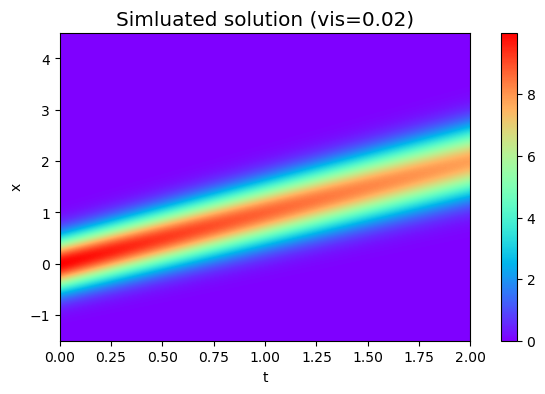

In [6]:
fig = plt.figure(figsize=(8, 4))
u_true = (y_train.reshape(201, 193)).T 
ext = [0 ,t_T, x_l, x_u]     # plot boundary 
mesh2 = plt.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.25); 
plt.colorbar(mesh2); 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('Simluated solution (vis=%s)' %(vis), fontsize='x-large'); 

Fast randomization PINN (FrPINN)

In [7]:
BS_pde = 5000

# no. neurons
n_node = 400
# n_node = BS_pde + data_ic.shape[0] + data_bc.shape[0] 

# choose seed
seed = 0

# weight & bias dist.
dscale = 10
initializer = jax.nn.initializers.variance_scaling(scale=dscale, distribution='uniform', mode='fan_in')
weights_x = initializer(jax.random.PRNGKey(seed), (1, n_node), jnp.float32).flatten()
weights_t = initializer(jax.random.PRNGKey(seed+1), (1, n_node), jnp.float32).flatten()
bias = initializer(jax.random.PRNGKey(seed+2), (1, n_node), jnp.float32).flatten()

In [8]:
# construct randomization PINN for linear PDEs
def get_f(x, t):
    f = x*weights_x + t*weights_t + bias
    f = jnp.sin(f)
    return f

# obtain f_t
def get_f_t(get_f, x, t):
    f_t = jacfwd(get_f, argnums=1)(x, t)
    return f_t

# obtain f_x
def get_f_x(get_f, x, t):
    f_x = jacfwd(get_f, argnums=0)(x, t)
    return f_x

# obtain f_xx    
def get_f_xx(get_f, x, t):
    f_xx = hessian(get_f, argnums=0)(x, t)
    return f_xx

f_t_vmap = vmap(get_f_t, in_axes=(None, 0, 0))
f_x_vmap = vmap(get_f_x, in_axes=(None, 0, 0))
f_xx_vmap = vmap(get_f_xx, in_axes=(None, 0, 0))

Minibatching

In [9]:

# BS_ic = 193

@jit
def minibatch(train_iter):
    _batch_pde = jax.random.choice(random.PRNGKey(train_iter), label_pde.shape[0], (BS_pde,))
    batch_data_pde, batch_data_ic,  batch_data_bc = data_pde[_batch_pde], data_ic, data_bc
#     _batch_ic = jax.random.choice(random.PRNGKey(train_iter), label_ic.shape[0], (BS_ic,))    
#     batch_data_pde, batch_data_ic = data_pde[_batch_pde], data_ic[_batch_ic]
    return (batch_data_pde, batch_data_ic, batch_data_bc)

In [10]:
train_iter = 0
batch_data_pde, batch_data_ic, batch_data_bc = minibatch(train_iter)
print (batch_data_pde.shape, batch_data_ic.shape, batch_data_bc.shape)

(5000, 2) (193, 2) (402, 2)


Least square problem

In [11]:
# compute hidden node outputs / derivaties & construct least square problem
@jit
def compute_matrix(batch_data_pde, batch_data_ic, batch_data_bc):
    # populate PDE sub-matrix given sample (x, t)
    x, t = jnp.array_split(batch_data_pde, 2, axis=1)
    f_t = f_t_vmap(get_f, x, t)[:,:,0]
    f_x = f_x_vmap(get_f, x, t)[:,:,0]
    f_xx = f_xx_vmap(get_f, x, t)[:,:,0,0]
    # PDE: u_t + c*u_x = vis*u_xx
    f_pde = f_t + c*f_x - vis*f_xx
    # populate BC sub-matrix given sample (x, t)
    x_ic, t_ic = jnp.array_split(batch_data_ic, 2, axis=1)
    f_ic = get_f(x_ic, t_ic)
    x_bc, t_bc = jnp.array_split(batch_data_bc, 2, axis=1)
    f_bc = get_f(x_bc, t_bc)

    # construct least square problem
    A = jnp.vstack([f_pde, f_ic, f_bc])
    b = jnp.vstack([jnp.zeros((f_pde.shape[0], 1)), label_ic, label_bc])   
    #b = jnp.vstack([jnp.zeros((f_pde.shape[0], 1)), jnp.zeros((f_ic.shape[0], 1))]) 
    return (A, b)

In [12]:
A, b = compute_matrix(batch_data_pde, batch_data_ic, batch_data_bc)
print (A.shape, b.shape)

(5595, 400) (5595, 1)


In [13]:
# solve least square
w, ssr, rank, _ = jnp.linalg.lstsq(A, b)
print (dscale, rank, ssr[0])

10 349 0.14262675214362813


In [14]:
# solution
@jit
def get_u(inputs, w):
    x, t = jnp.array_split(inputs, 2, axis=1)
    f = get_f(x, t)
    return (f @ w)

8.766215934948927e-05


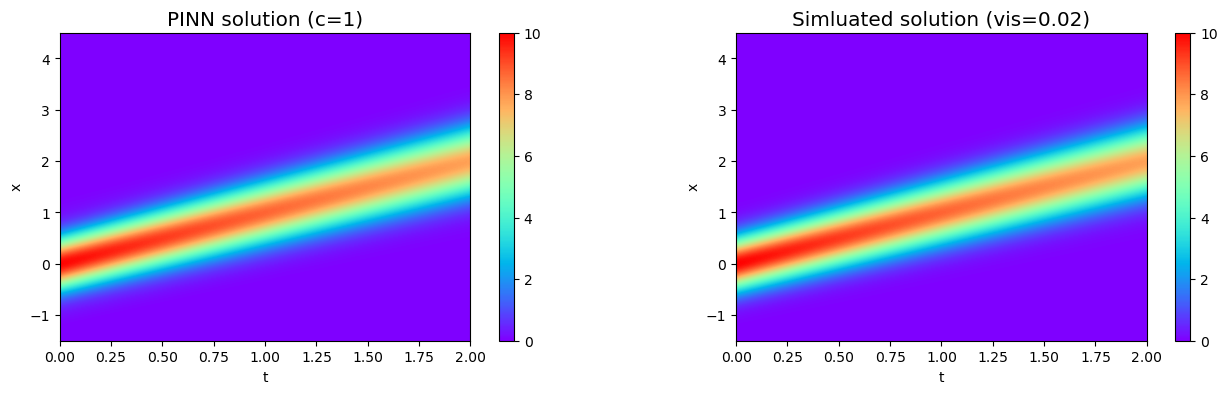

In [15]:
# plot solution vs. ground truth
u = get_u(x_train, w)
print (jnp.mean(jnp.square(y_train - u)))

fig = plt.figure(figsize=(16, 4))
ext = [0 ,t_T, x_l, x_u]     # plot boundary 

ax1 = fig.add_subplot(1,2,1)
u_pinn = (u.reshape(-1, 193)).T 
mesh2 = plt.imshow(u_pinn, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.25, vmin=0, vmax=10); 
plt.colorbar(mesh2); 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('PINN solution (c=%s)' %(c), fontsize='x-large'); 

ax1 = fig.add_subplot(1,2,2)
u_true = (y_train.reshape(-1, 193)).T 
mesh2 = plt.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.25, vmin=0, vmax=10); 
plt.colorbar(mesh2); 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('Simluated solution (vis=%s)' %(vis), fontsize='x-large'); 

7.658321585215896e-05


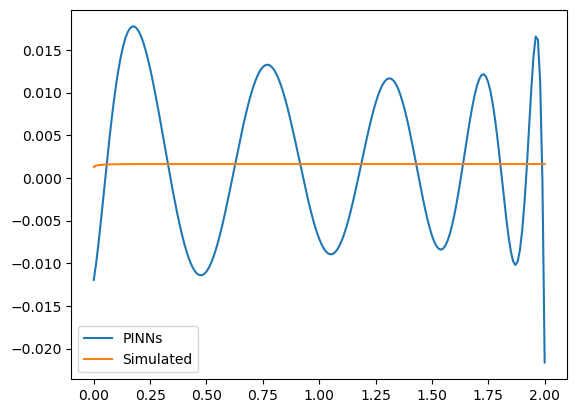

In [16]:
_bc = (x_train[:,0] == -1.5)
data_bc, label_bc = x_train[_bc], y_train[_bc]
u_bc = get_u(data_bc, w)
plt.plot(data_bc[:,1], u_bc, label='PINNs');
plt.plot(data_bc[:,1], label_bc, label='Simulated');
plt.legend();

print (jnp.mean(jnp.square(u_bc.flatten() - label_bc.flatten())))

0.000476729931046266


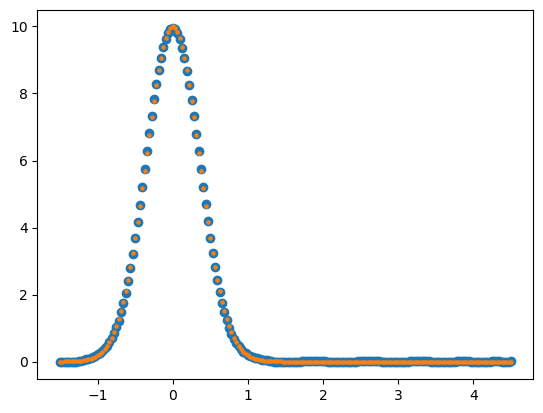

In [17]:
u = get_u(batch_data_ic, w)
plt.scatter(batch_data_ic[:,0], u);
plt.scatter(batch_data_ic[:,0], t_ic(batch_data_ic[:, 0]), s=5);
print (jnp.mean(jnp.square(t_ic(batch_data_ic[:, 0]).flatten() - u.flatten())))